# Physics-Informed Neural Networks

In this workshop, you will implement physics-informed neural networks (PINNs) and apply it to two different problems: a forward and a inverse one.

For both of them, most of the code is already written - the goal is for you to take away the most important concepts. As shown in the lecture, the physics-informed component is to be encoded via the loss function, and that will be the emphasis of this workshop.

In [ ]:
from utils import *

%matplotlib inline
plt.rcParams.update({"figure.figsize": (6, 4), "font.size": 12})

# Sets up GPU for PyTorch if available
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f"Using device: {device}")

In [2]:
config = {
    'use_tqdm': True,
    'seed': 2,
}

torch.manual_seed(config['seed'])
np.random.seed(config['seed'])


### Forward Problem: Burger's Equation

PINNs were first proposed in [Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10561) and [Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations](https://arxiv.org/abs/1711.10566).

These papers suggest using neural networks to model phenomena in physics and give an example with a PINN for the Burger's equation, since this equation is simple to understand, but can be tricky to solve numerically. In the first part of this workshop we are going to solve a forward problem (data-driven solution) with a PINN for the Burger's equation.

A **forward problem** in the context of differential equations is simply this:

> **“Given a governing equation together with its initial and boundary conditions, predict the solution field.”**

In other words, we already know

1. **The physics**—the partial differential equation (PDE) itself (here, the viscous Burgers’ equation),
2. **The parameters**—for Burgers’ equation, the viscosity $\lambda$ is known,
3. **The constraints**—initial data $u(x,0)$ and boundary values on $x=-1$ and $x=1$.

#### Forward vs. Inverse

It's important not to conflate the **forward problem** (solve for $u$ when $\lambda$ and the PDE form are known) with the **inverse problem** (infer unknown parameters—like $\lambda$ or even the form of the nonlinearity—given measurements of $u$). PINNs tackle both, but in this first part we focus strictly on the **forward problem**, i.e., *data-driven solution* rather than *data-driven discovery*.

#### Your task

Your task is to compute $u(x,t)$ for $x\in[-1,1]$, $t\in[0,1]$ by training a Physics-Informed Neural Network that learns $u(x,t)$ satisfying

$$
\frac{\partial u}{\partial t} + u\,\frac{\partial u}{\partial x}
\;=\;\lambda\,\frac{\partial^2 u}{\partial x^2},
$$

subject to

$$
u(x,0) = -\sin(\pi x), 
\qquad
u(-1,t) = u(1,t) = 0,
$$

In [ ]:
path = '../data/burgers_shock.mat'  # adjust path as needed
icbc_points = 100
f_points = 10000

x, t, X_mesh, T_mesh, u_target_mesh, Phi_icbc, u_icbc, Phi_f = load_data_burgers(
    path, icbc_points, f_points
)

# move data to GPU if available
Phi_icbc, u_icbc, Phi_f = [v.to(device) for v in (Phi_icbc, u_icbc, Phi_f)]
Phi_f.requires_grad_(True) # this is key for the loss function!

In [4]:
class BurgersNet(nn.Module):
    def __init__(self, layers=(2, *[20]*8, 1)):
        super().__init__()
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                modules.append(nn.Tanh())
        self.net = nn.Sequential(*modules)
    def forward(self, x):
        return self.net(x)

model = BurgersNet().to(device)

In [5]:
def pinn_loss(u_icbc_pred, u_icbc_true, u_f_pred, grads, viscosity=0.01/np.pi):
    ut, ux, uxx = grads
    mse_icbc = nn.MSELoss()(u_icbc_pred, u_icbc_true)
    res = ut + u_f_pred * ux - viscosity * uxx
    mse_pde = torch.mean(res**2)
    return mse_icbc + mse_pde, mse_icbc.item(), mse_pde.item()

In [6]:
epochs = 2000
lr = 2e-3
scheduler_step = 2000
scheduler_gamma = 0.5
lbfgs_start = 1700

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
loss_hist = []
metrics = {}

def closure():
    optimizer.zero_grad()
    # IC/BC prediction
    u_icbc_pred = model(Phi_icbc)
    # Collocation prediction
    u_f_pred = model(Phi_f)
    grads1 = grad(u_f_pred.sum(), Phi_f, create_graph=True)[0]
    ux = grads1[:,0:1]
    ut = grads1[:,1:2]
    uxx = grad(ux.sum(), Phi_f, create_graph=True)[0][:,0:1]
    loss_val, l_icbc, l_pde = pinn_loss(u_icbc_pred, u_icbc, u_f_pred, (ut, ux, uxx))
    metrics['loss_val'] = loss_val
    metrics['l_icbc'] = l_icbc
    metrics['l_pde'] = l_pde
    loss_val.backward()
    return loss_val

In [ ]:
iterable = tqdm(range(1, epochs+1), disable=not config['use_tqdm'])
for epoch in iterable:
    if epoch == lbfgs_start:
        print("Switching to LBFGS optimizer")
        optimizer = torch.optim.LBFGS(
            model.parameters(),
            tolerance_grad=1e-6,
        )
    if epoch < lbfgs_start:
        loss = closure()
        optimizer.step()
        scheduler.step()
    else:
        loss = optimizer.step(closure)

    loss_hist.append((metrics['loss_val'].item(), metrics['l_icbc'], metrics['l_pde']))
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total: {loss_hist[-1][0]:.3e} "
              f"| ICBC: {loss_hist[-1][1]:.3e} | PDE: {loss_hist[-1][2]:.3e}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch  100 | Total: 1.461e-01 | ICBC: 1.351e-01 | PDE: 1.098e-02
Epoch  200 | Total: 8.210e-02 | ICBC: 5.722e-02 | PDE: 2.488e-02
Epoch  300 | Total: 5.841e-02 | ICBC: 4.146e-02 | PDE: 1.696e-02
Epoch  400 | Total: 5.982e-02 | ICBC: 3.579e-02 | PDE: 2.403e-02
Epoch  500 | Total: 3.737e-02 | ICBC: 2.446e-02 | PDE: 1.291e-02
Epoch  600 | Total: 3.551e-02 | ICBC: 2.404e-02 | PDE: 1.147e-02
Epoch  700 | Total: 2.926e-02 | ICBC: 2.006e-02 | PDE: 9.202e-03
Epoch  800 | Total: 3.061e-02 | ICBC: 2.120e-02 | PDE: 9.413e-03
Epoch  900 | Total: 2.055e-02 | ICBC: 1.300e-02 | PDE: 7.542e-03
Epoch 1000 | Total: 3.802e-02 | ICBC: 2.799e-02 | PDE: 1.004e-02
Epoch 1100 | Total: 1.781e-02 | ICBC: 1.146e-02 | PDE: 6.344e-03
Epoch 1200 | Total: 1.142e-02 | ICBC: 6.513e-03 | PDE: 4.910e-03
Epoch 1300 | Total: 2.890e-02 | ICBC: 2.047e-02 | PDE: 8.423e-03
Epoch 1400 | Total: 6.806e-03 | ICBC: 3.503e-03 | PDE: 3.304e-03
Epoch 1500 | Total: 5.150e-03 | ICBC: 2.348e-03 | PDE: 2.802e-03
Epoch 1600 | Total: 4.114

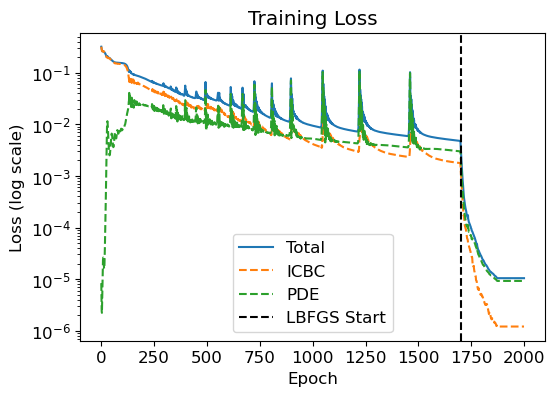

In [ ]:
loss_arr = np.array(loss_hist)
plt.figure()
plt.semilogy(loss_arr[:,0], label='Total')
plt.semilogy(loss_arr[:,1], '--', label='ICBC')
plt.semilogy(loss_arr[:,2], '--', label='PDE')
plt.axvline(x=config['lbfgs_start'], color='k', linestyle='--', label='LBFGS Start')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss')
plt.show()

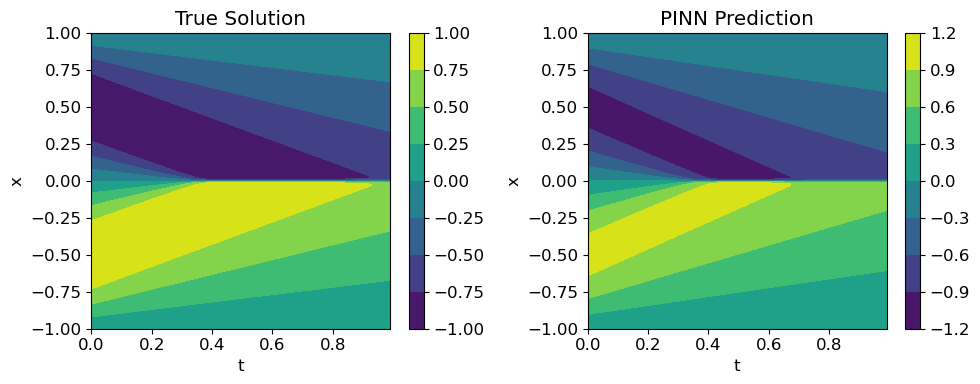

In [ ]:
with torch.no_grad():
    Phi_all = torch.from_numpy(
        np.hstack([X_mesh.reshape(-1,1), T_mesh.reshape(-1,1)])
    ).float().to(device)
    u_pred = model(Phi_all).cpu().numpy().reshape(u_target_mesh.shape)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
# True solution
cf0 = axes[0].contourf(T_mesh, X_mesh, u_target_mesh, cmap='viridis')
axes[0].set_title('True Solution')
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
fig.colorbar(cf0, ax=axes[0])
# PINN prediction
cf1 = axes[1].contourf(T_mesh, X_mesh, u_pred, cmap='viridis')
axes[1].set_title('PINN Prediction')
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
fig.colorbar(cf1, ax=axes[1])

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
line_true, = ax.plot([], [], 'b-', label='True')
line_pred, = ax.plot([], [], 'r--', label='NN pred')
ax.set_xlim(float(x.min()), float(x.max()))
ymin = min(u_target_mesh.min(), u_pred.min())
ymax = max(u_target_mesh.max(), u_pred.max())
ax.set_ylim(ymin, ymax)
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()

def init():
    line_true.set_data([], [])
    line_pred.set_data([], [])
    return line_true, line_pred

def update(frame):
    xx = x.flatten()
    y_true = u_target_mesh[frame, :]
    y_pred = u_pred[frame, :]
    line_true.set_data(xx, y_true)
    line_pred.set_data(xx, y_pred)
    ax.set_title(f't = {float(t[frame,0]):.3f}')
    return line_true, line_pred

ani = FuncAnimation(fig, update, frames=u_pred.shape[0],
                    init_func=init, blit=True, interval=100)

HTML(ani.to_jshtml())

In [ ]:
error_l2 = np.linalg.norm((u_pred - u_target_mesh).ravel())/np.linalg.norm(u_target_mesh.ravel())
print(f"Relative L2 Error: {error_l2:.3e}")

Relative L2 Error: 2.787e-03
